# Pet Dog Behavior Study Analysis

## 1. Workspace Setup

In [2]:
# Imports accounted for.
import sqlite3
import pandas as pd
import plotly.offline as py
import plotly.graph_objs as go
from matplotlib_venn import venn2
import matplotlib.pyplot as plt

# Imports unaccounted for.
import textwrap
import scipy.stats as scs
from IPython.display import display
import plotly.figure_factory as ff

# IPython magics for this notebook.
%matplotlib inline

# Initiate plotly IPython notebook mode.
py.init_notebook_mode(connected=True)

# Establish a connection to the database.
con = sqlite3.connect('../data/processed/processed.db')

## 2. Overall Prevalence of Behavior Problems

Prevalence is defined as the proportion of a population found to be affected by a medical condition. This section aims to calculate the aggregate prevalence of the most common behavior problems in a given canine population.

### 2.1 Count gross and adjusted responses:

In [3]:
# Create the necessary dataframe.
query = ('SELECT record_id, question_reason_for_part_3, q02_score FROM users JOIN dogs '
         'USING(record_id)')
df_gross = pd.read_sql_query(query, con)
df_gross.columns = ['id', 'suspicion', 'problems']

# Get a count of the total number of dogs.
cnt_total_dogs = len(df_gross.index)

# Get a count of the dogs with reported behavior problem.
# If the "problems" column does not equal zero, then a behavior problem was reported.
cnt_total_dogs_w_problems = len(df_gross[df_gross['problems'] != '0'].index)

# Create an adjusted dataframe by removing biased results.
# A result is considered biased if a participant listed "suspicion of a behavior problem" as a
# reason for joining the study.
df_adjusted = df_gross[df_gross['suspicion'] == '0']

# Get a count of the total number of dogs from the adjusted dataframe.
cnt_total_dogs_adjusted = len(df_adjusted.index)

# Get a count of the dogs with a reported behavior problem from the adjusted dataframe.
cnt_total_dogs_w_problems_adjusted = len(df_adjusted[df_adjusted['problems'] != '0'].index)

# Display the count results.
print('Total number of dogs: %d' %cnt_total_dogs)
print('Total number of dogs with a reported behavior problem: %d' %cnt_total_dogs_w_problems)
print('Adjusted total number of dogs: %d' %cnt_total_dogs_adjusted)
print('Adjusted total number of dogs with a reported behavior problem: %d'
      %cnt_total_dogs_w_problems_adjusted)

Total number of dogs: 5018
Total number of dogs with a reported behavior problem: 4407
Adjusted total number of dogs: 3749
Adjusted total number of dogs with a reported behavior problem: 3207


### 2.2 Calculate prevalence:

In [4]:
# Calculate the gross prevalence.
prevalence_gross = (cnt_total_dogs_w_problems / cnt_total_dogs) * 100

# Calculate the adjusted prevalence.
prevalence_adjusted = (cnt_total_dogs_w_problems_adjusted / cnt_total_dogs_adjusted) * 100

# Calculate the difference between the gross and adjusted prevalence.
diff_prevalence = prevalence_adjusted - prevalence_gross
sign = '+' if diff_prevalence > 0 else ''

# Display the prevalence results.
print('Gross prevalence: %.2f%% (%d/%d)'
      %(prevalence_gross, cnt_total_dogs_w_problems, cnt_total_dogs))
print('Adjusted prevalence: %.2f%% (%d/%d)'
      %(prevalence_adjusted, cnt_total_dogs_w_problems_adjusted, cnt_total_dogs_adjusted))
print('Shift in prevalence as a result of adjustment: %s%.2f%%' %(sign, diff_prevalence))

Gross prevalence: 87.82% (4407/5018)
Adjusted prevalence: 85.54% (3207/3749)
Shift in prevalence as a result of adjustment: -2.28%


## 3. Prevalence of Individual Behavior Problems

This section aims to calculate the prevalence for each behavior problem included in the study. The adjusted dataset is utilized to eliminate potential bias.

### 3.1 Determine count and prevalence for each behavior problem:

In [5]:
# Create the necessary dataframe.
query = ('SELECT question_reason_for_part_3, q02_main_1, q02_main_2, q02_main_3, '
         'q02_main_4, q02_main_5, q02_main_6, q02_main_7, q02_main_8, q02_main_9, '
         'q02_main_10, q02_main_12, q02_main_13 FROM users JOIN dogs '
         'USING(record_id)')
df = pd.read_sql_query(query, con)
df.columns = ['suspicion', 'aggression', 'fear/anxiety', 'compulsion', 'house soiling',
              'excessive barking', 'jumping', 'mounting', 'fecal consumption', 'destruction',
              'rolling in repulsive objects', 'escape', 'hyperactivity']

# Remove biased results and discard suspicion column.
df = df[df['suspicion'] == '0']
df.drop('suspicion', axis=1, inplace=True)

# Convert columns to integer type.
for col in df:
    df[col] = pd.to_numeric(df[col])

# Get individual behavior problem counts and display as a table.
sums = df.sum()
sums = sums.sort_values(ascending=False)

# Calculate the prevalence of each behavior problem.
total_dogs = len(df.index)
prevalence_cal = lambda x: (x / total_dogs) * 100
prevalences = sums.apply(prevalence_cal)

# Get individual behavior problem counts and display as a table.
trace = go.Table(
    header=dict(values=['Behavior Problem', 'Count', 'Prevalence (%)'],
                fill = dict(color='#B0C4DE'),
                align = ['left'] * 5),
    cells=dict(values=[sums.index.values, sums.values, prevalences.values],
               align = ['left'] * 5,
               format = [None, 'd', '.2f']))
data = [trace] 
layout = dict(width=700, height=450)
fig = dict(data=data, layout=layout)
py.iplot(fig)

### 3.2 Graphical presentation of individual prevalences:

In [6]:
prevalences = prevalences.sort_values(ascending=True)
trace = go.Bar(
    x=prevalences.values,
    y=prevalences.index.values,
    orientation='h')
data = [trace]
layout = go.Layout(title='Prevalence of Behavior Problems',
                   xaxis=dict(title='Prevalence (%)'),
                   yaxis=dict(title='Behavior Problem',
                              automargin=True,
                              tickangle=30,
                              tickprefix=' ',
                              ticksuffix=' '),
                   width=700,
                   height=500
                  )
fig = dict(data=data, layout=layout)
py.iplot(fig)

## 4. Reasons for Joining the Study

### 4.1 Preparation of data:

In [7]:
# Create the necessary dataframe.
query = ('SELECT question_reason_for_part_1, question_reason_for_part_2, '  
         'question_reason_for_part_3, question_reason_for_part_4, '
         'question_reason_for_part_5 FROM users')
df = pd.read_sql_query(query, con)
df.columns = ['Love', 'Shelter Animals', 'Behavior Problems', 'Work', 'Other']
for col in df:
    df[col] = pd.to_numeric(df[col])

### 4.2 Breakdown of reasons for joining the study:

In [8]:
# Create a bar graph to illustrate breakdown of responses.
data = [go.Bar(x=df.columns, y=df.sum())]
layout = go.Layout(title="Motivation for Participation",
                   xaxis=dict(title='Motivation'),
                   yaxis=dict(title='Count'),
                   autosize=False, width=500, height=500)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

# NOTE: This does not include a count of users who did not provide a reason.

## ?. Separation Anxiety, Noise Phobia, and Thunderstorm Phobia

### ?.1 Preparation of data

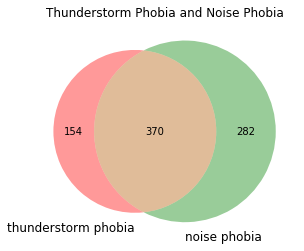

Chi-squared Test of Independence for thunderstorm phobia and noise phobia:
chi2 = 1200.877626, p = 3.93E-263, dof = 1
The resulting p-value is below the set significance threshold (0.01).


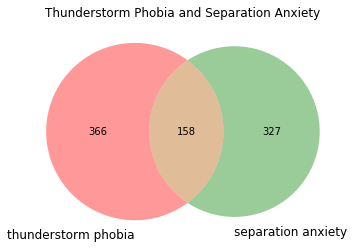

Chi-squared Test of Independence for thunderstorm phobia and separation anxiety:
chi2 = 160.293122, p = 9.76E-37, dof = 1
The resulting p-value is below the set significance threshold (0.01).


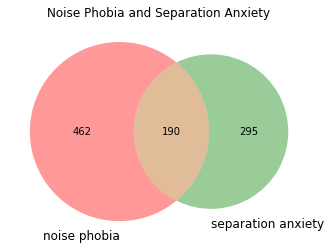

Chi-squared Test of Independence for noise phobia and separation anxiety:
chi2 = 184.001984, p = 6.48E-42, dof = 1
The resulting p-value is below the set significance threshold (0.01).


In [20]:
# Create the necessary dataframe.
query = ('SELECT question_reason_for_part_3, q04_1, q04_2, q04_9 FROM users JOIN dogs '
         'USING(record_id)')
df = pd.read_sql_query(query, con)
df.columns = ['suspicion', 'thunderstorm phobia', 'noise phobia', 'separation anxiety']

# Remove biased results and discard suspicion column.
df = df[df['suspicion'] == '0']
df.drop('suspicion', axis=1, inplace=True)

# Convert all columns to type integer.
for col in df:
    df[col] = pd.to_numeric(df[col])

# Set a significance level.
sig_p = 0.01

pairs = [['thunderstorm phobia', 'noise phobia'],
         ['thunderstorm phobia', 'separation anxiety'],
         ['noise phobia', 'separation anxiety']]

titles = ['Thunderstorm Phobia and Noise Phobia',
          'Thunderstorm Phobia and Separation Anxiety',
          'Noise Phobia and Separation Anxiety']

counter = 0
for pair in pairs:
    # Create a contingency table.
    contingency = pd.crosstab(df[pair[0]], df[pair[1]])
    # Convert the cross tabulated dataframe to a series of sums.
    d = {pair[0]: contingency[0][1],
         pair[1]: contingency[1][0],
         'both': contingency[1][1]}   
    cross_sums = pd.Series(d)
    # Display the cross tabulated data as a venn diagram.
    labels = cross_sums.index.values
    venn2(cross_sums, set_labels=labels[0:2])
    plt.title(titles[counter])
    plt.show()
    # Execute a chi-squared test of independence.
    print('Chi-squared Test of Independence for %s and %s:' %(pair[0], pair[1]))
    c, p, dof, expected = scs.chi2_contingency(contingency, correction=False)
    print('chi2 = %f, p = %.2E, dof = %d' %(c, p, dof))
    if p < sig_p:
        print('The resulting p-value is below the set significance threshold (%.2f).' %sig_p)
    counter += 1

### ?.2 Further exploration

In [11]:
# Create a contingency table.
contingency = pd.crosstab(df['separation anxiety'], [df['noise phobia'],
                                                     df['thunderstorm phobia']])
display(contingency)


# Execute a chi-squared test of independence.
title = ('Chi-squared Test of Independence for separation anxiety and the combination of '
         'noise and thunderstorm phobia:')
print(textwrap.fill(title, width=90))
c, p, dof, expected = scs.chi2_contingency(contingency, correction=False)
print('chi2 = %f, p = %.2E, dof = %d' %(c, p, dof))
if p < sig_p:
    print('The resulting p-value is below the set significance threshold (%.2f).' %sig_p)

noise phobia            0         1     
thunderstorm phobia     0    1    0    1
separation anxiety                      
0                    2695  107  203  259
1                     248   47   79  111

Chi-squared Test of Independence for separation anxiety and the combination of noise and
thunderstorm phobia:
chi2 = 247.979410, p = 1.79E-53, dof = 3
The resulting p-value is below the set significance threshold (0.01).


## ?. Compulsion and Fearful/Anxious Behaviors

### ?.1 Preparation of data

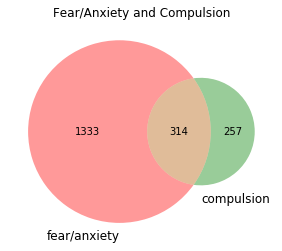

In [12]:
# Create the necessary hdataframe.
query = ('SELECT question_reason_for_part_3, q02_main_2, q02_main_3 FROM users JOIN dogs '
         'USING(record_id)')
df = pd.read_sql_query(query, con)
df.columns = ['suspicion', 'fear/anxiety', 'compulsion']

# Remove biased results and discard suspicion column.
df = df[df['suspicion'] == '0']
df.drop('suspicion', axis=1, inplace=True)

# Convert all columns to type integer.
for col in df:
    df[col] = pd.to_numeric(df[col])

# Cross tabulate the relevant columns.
contingency = pd.crosstab(df['fear/anxiety'], df['compulsion'])

# Convert the cross tabulated dataframe to a series of sums.
d = {'fear/anxiety': contingency[0][1],
     'compulsion': contingency[1][0],
     'both': contingency[1][1]}   
cross_sums = pd.Series(d)

# Display the cross tabulated data as a venn diagram.
labels = cross_sums.index.values
venn2(cross_sums, set_labels=labels[0:2])
plt.title('Fear/Anxiety and Compulsion')
plt.show()

In [13]:
# Execute a chi-squared test of independence.
c, p, dof, expected = scs.chi2_contingency(contingency, correction=False)
print('Chi-square Test of Independence:')
print('chi2 = %f, p = %.2E, dof = %d' %(c, p, dof))
if p < sig_p:
    print('The resulting p-value is below the set significance threshold (%.2f).' %sig_p)

Chi-square Test of Independence:
chi2 = 33.448407, p = 7.32E-09, dof = 1
The resulting p-value is below the set significance threshold (0.01).


## ?. Aggression and Fearful/Anxious Behavior

### ?.1 Preparation of data

In [14]:
# Create the necessary dataframe.
query = ('SELECT q02_main_1, q02_main_2 FROM dogs')
df = pd.read_sql_query(query, con)
df.columns = ['aggression', 'fearful/anxious behavior']
for col in df:
    df[col] = pd.to_numeric(df[col])

### ?.2 Tables and calculations

In [15]:
# Create a contingency table.
contingency = pd.crosstab(df['aggression'], df['fearful/anxious behavior'])
display(contingency)

# Execute a chi-squared test of independence.
c, p, dof, expected = scs.chi2_contingency(contingency, correction=False)
print('Chi-square Test of Independence:')
print('chi2 = %f, p = %.2E, dof = %d' %(c, p, dof))
if p < sig_p:
    print('The resulting p-value is below the set significance threshold (%.2f).' %sig_p)

fearful/anxious behavior,0,1
aggression,,
0,1905,1325
1,726,1062


Chi-square Test of Independence:
chi2 = 155.793414, p = 9.39E-36, dof = 1
The resulting p-value is below the set significance threshold (0.01).
